### Project

In [28]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import numpy as np
import optuna
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score,roc_curve
import matplotlib.pyplot as plt

In [20]:
# load dataset
url = 'adult.csv'
df = pd.read_csv(url)

In [21]:
#inforamation
print("Information about dataset:\n",df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
Information about dataset:
 None


In [22]:
#eda
# -handling missing values
df["workclass"] = df["workclass"].replace("?", "Unknown")
print("workclass ? replaced with unknown")

df["native.country"] = df["native.country"].replace("?", "Unknown")
print("native.country ? replaced with unknown")

df["occupation"] = df["occupation"].replace("?", "Unknown")
print("occupation ? replaced with unknown")

workclass ? replaced with unknown
native.country ? replaced with unknown
occupation ? replaced with unknown


In [23]:
#divide in parts of features and targets
X = df.drop(columns=["income"])
y = df["income"]


In [24]:
X.columns = X.columns.str.strip()

onehot_cols = ["workclass", "marital.status", "relationship", "race"]
label_cols = ["education", "sex"]
target_cols = ["occupation", "native.country"]
numerical = ["age", "fnlwgt", "education.num", "capital.gain", "capital.loss", "hours.per.week"]

# OneHot Encoding
X = pd.get_dummies(X, columns=onehot_cols, drop_first=True)

# Label Encoding
for col in label_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Target Encoding
te = TargetEncoder()
X[target_cols] = te.fit_transform(X[target_cols], y)

# Scale numerical columns
scaler = StandardScaler()
X[numerical] = scaler.fit_transform(X[numerical])

# Encode target
y = y.map({"<=50K": 0, ">50K": 1})

print("Encoding completed successfully!")

Encoding completed successfully!


In [25]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print("data balanced")

data balanced


In [26]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

Accuracy of Logistic Regression: 0.8299959546925566
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      4955
           1       0.81      0.85      0.83      4933

    accuracy                           0.83      9888
   macro avg       0.83      0.83      0.83      9888
weighted avg       0.83      0.83      0.83      9888

ROC AUC Score: 0.8300479912154863


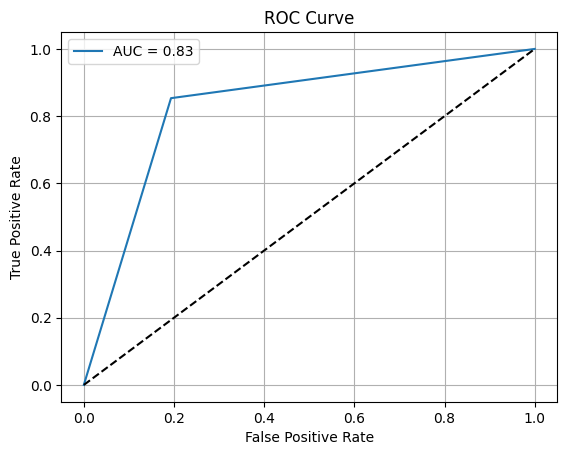

In [29]:
# from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(x_train, y_train)
y_pred = log_model.predict(x_test)

#predicting accuracy
acc_log = accuracy_score(y_test, y_pred)
print("Accuracy of Logistic Regression:", acc_log)
print("Classification Report:\n", classification_report(y_test, y_pred))

roc_score = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", roc_score)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label=f"AUC = {roc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# # from sklearn.ensemble import RandomForestClassifier

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }
    
    clf = RandomForestClassifier(random_state=42, **params)
    score = cross_val_score(clf, x_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    return score.mean()

# Optimize with Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Train Final Model on Best Parameters 
best_params = study.best_params
print("Best Parameters from Optuna:\n", best_params)

best_model = RandomForestClassifier(random_state=42, **best_params)
best_model.fit(x_train, y_train)

# Evaluate on Test Set 
y_pred = best_model.predict(x_test)
acc = accuracy_score(y_test, y_pred)

print(f"\nAccuracy on Test Set of Random forest: {acc:.4f}")
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred))

[I 2025-07-25 22:12:38,540] A new study created in memory with name: no-name-d619e825-d40e-47af-b6da-0fa056796879
[I 2025-07-25 22:12:43,654] Trial 0 finished with value: 0.8419801779935275 and parameters: {'n_estimators': 58, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 0.8419801779935275.
[I 2025-07-25 22:12:50,570] Trial 1 finished with value: 0.8477447411003235 and parameters: {'n_estimators': 119, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 1 with value: 0.8477447411003235.
[I 2025-07-25 22:13:13,359] Trial 2 finished with value: 0.8365948624595468 and parameters: {'n_estimators': 189, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 1 with value: 0.8477447411003235.
[I 2025-07-25 22:13:21,022] Trial 3 finished with value: 0.8635972896440128 and parameters: {'n_estimators': 158, 'max_depth': 13, 'min_sa

Best Parameters from Optuna:
 {'n_estimators': 96, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}

Accuracy on Test Set of Random forest: 0.8945

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89      4955
           1       0.89      0.90      0.89      4933

    accuracy                           0.89      9888
   macro avg       0.89      0.89      0.89      9888
weighted avg       0.89      0.89      0.89      9888



In [11]:
# # from sklearn.ensemble import GradientBoostingClassifier

def objective(trial):
    # Define hyperparameters to tune
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300, step=10),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.01, 0.05, 0.1, 0.2]),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "random_state": 42
    }
    
    # Initialize model with trial parameters
    model = GradientBoostingClassifier(**params)
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

# Create Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Best results
print("Best Parameters:", study.best_params)
print("Best Accuracy:", study.best_value)

# Retrain with best params
best_model = GradientBoostingClassifier(**study.best_params, random_state=42)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)

# Final Evaluation
acc = accuracy_score(y_test, y_pred)
print("\nGradient Boosting Final Accuracy:", acc)
print("\nGradient boosting Classification Report:\n", classification_report(y_test, y_pred))

[I 2025-07-25 22:17:34,444] A new study created in memory with name: no-name-947c4fd4-7406-4598-9d3b-907e4df8b089
[I 2025-07-25 22:17:40,826] Trial 0 finished with value: 0.861549352750809 and parameters: {'n_estimators': 50, 'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 5, 'subsample': 0.7961339424376881}. Best is trial 0 with value: 0.861549352750809.
[I 2025-07-25 22:18:15,669] Trial 1 finished with value: 0.9078681229773463 and parameters: {'n_estimators': 170, 'learning_rate': 0.2, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5, 'subsample': 0.7239703734664811}. Best is trial 1 with value: 0.9078681229773463.
[I 2025-07-25 22:18:44,783] Trial 2 finished with value: 0.9085760517799353 and parameters: {'n_estimators': 160, 'learning_rate': 0.2, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 4, 'subsample': 0.761775391389016}. Best is trial 2 with value: 0.9085760517799353.
[I 2025-07-25 22:18:57,782] Trial 3 finished w

Best Parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.8753084526156901}
Best Accuracy: 0.9139360841423948

Gradient Boosting Final Accuracy: 0.9139360841423948

Gradient boosting Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.91      4955
           1       0.92      0.90      0.91      4933

    accuracy                           0.91      9888
   macro avg       0.91      0.91      0.91      9888
weighted avg       0.91      0.91      0.91      9888



In [ ]:
# from xgboost import XGBClassifier
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        "random_state": 42,
        "use_label_encoder": False,
        "eval_metric": "logloss"
    }

    model = XGBClassifier(**params)
    model.fit(x_train, y_train)

    preds = model.predict(x_test)
    return accuracy_score(y_test, preds)

# Run Optuna Study ---
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Train final model with best params ---
print("Best Parameters:", study.best_params)
best_model = XGBClassifier(**study.best_params, use_label_encoder=False, eval_metric="logloss")
best_model.fit(x_train, y_train)

# Test Accuracy ---
y_pred = best_model.predict(x_test)
print("\nAccuracy on Test Set:", accuracy_score(y_test, y_pred))
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred))